<a href="https://colab.research.google.com/github/kartikgill/The-GAN-Book/blob/main/Skill-01/Variational%20Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing useful libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import tensorflow
tensorflow.compat.v1.disable_eager_execution()

# Load and show the Dataset

11493376/11490434 [==============================] - 0s 0us/step
Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


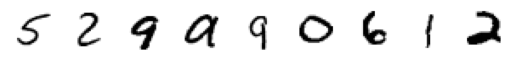

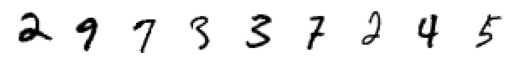

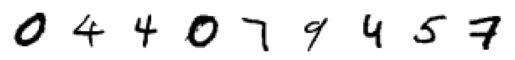

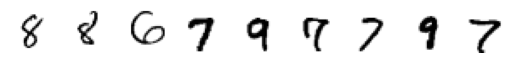

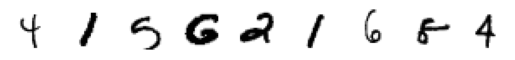

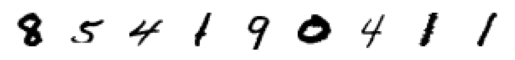

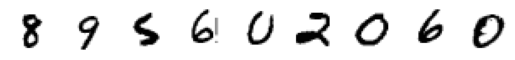

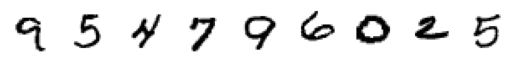

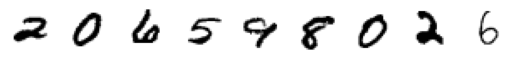

In [3]:
from tensorflow.keras.datasets import mnist

(trainX, trainy), (testX, testy) = mnist.load_data()

print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testy.shape))


for k in range(9):
    plt.figure(figsize=(9,9))
    for j in range(9):
        i = np.random.randint(0, 10000)
        plt.subplot(990 + 1 + j)
        plt.imshow(trainX[i], cmap='gray_r')
        plt.axis('off')
        #plt.title(trainy[i])
    plt.show()

# Prepare data for the model

In [4]:
train_data = trainX.astype('float32')/255
test_data = testX.astype('float32')/255

train_data = np.reshape(train_data, (60000, 28, 28, 1))
test_data = np.reshape(test_data, (10000, 28, 28, 1))

print (train_data.shape, test_data.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


# Define: Variational Autoencoder (VAE)

## Simple Convoutional Encoder

In [5]:
import tensorflow

input_data = tensorflow.keras.layers.Input(shape=(28, 28, 1))

encoder = tensorflow.keras.layers.Conv2D(64, (5,5), activation='relu')(input_data)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)

encoder = tensorflow.keras.layers.Conv2D(64, (3,3), activation='relu')(encoder)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)

encoder = tensorflow.keras.layers.Conv2D(32, (3,3), activation='relu')(encoder)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)

encoder = tensorflow.keras.layers.Flatten()(encoder)
encoder = tensorflow.keras.layers.Dense(16)(encoder)

## Sampling of latent features

In [6]:
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tensorflow.shape(distribution_variance)[0]
    random = tensorflow.keras.backend.random_normal(shape=(batch_size, tensorflow.shape(distribution_variance)[1]))
    return distribution_mean + tensorflow.exp(0.5 * distribution_variance) * random

## mean, log-variance and sampling layers

In [7]:
distribution_mean = tensorflow.keras.layers.Dense(2, name='mean')(encoder)
distribution_variance = tensorflow.keras.layers.Dense(2, name='log_variance')(encoder)
sampled_latent_encoding = tensorflow.keras.layers.Lambda(sample_latent_features)([distribution_mean, distribution_variance])

## Defining Encoder model, image -> latent distribution

In [8]:
encoder_model = tensorflow.keras.Model(input_data, sampled_latent_encoding)
encoder_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 24, 24, 64)   1664        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 12, 12, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 10, 10, 64)   36928       max_pooling2d[0][0]              
______________________________________________________________________________________________

## Define Decoder, latent point -> image

In [9]:
decoder_input = tensorflow.keras.layers.Input(shape=(2))
decoder = tensorflow.keras.layers.Dense(64)(decoder_input)
decoder = tensorflow.keras.layers.Reshape((1, 1, 64))(decoder)
decoder = tensorflow.keras.layers.Conv2DTranspose(64, (3,3), activation='relu')(decoder)

decoder = tensorflow.keras.layers.Conv2DTranspose(64, (3,3), activation='relu')(decoder)
decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)

decoder = tensorflow.keras.layers.Conv2DTranspose(64, (3,3), activation='relu')(decoder)
decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)

decoder_output = tensorflow.keras.layers.Conv2DTranspose(1, (5,5), activation='relu')(decoder)

In [10]:
decoder_model = tensorflow.keras.Model(decoder_input, decoder_output)
decoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                192       
_________________________________________________________________
reshape (Reshape)            (None, 1, 1, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 3, 3, 64)          36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 5, 5, 64)          36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 12, 12, 64)        3692

## Combined VAE model, that can be trained using backpropagation

In [11]:
sampled_latent_encoding = encoder_model(input_data)
decoded = decoder_model(sampled_latent_encoding)

In [12]:
autoencoder = tensorflow.keras.models.Model(input_data, decoded)

## Define custom Loss Function (Reconstruction Loss + KL-divergence-loss)

In [13]:
def get_loss(distribution_mean, distribution_variance):
    
    def get_reconstruction_loss(y_true, y_pred):
        reconstruction_loss = tensorflow.keras.losses.mse(y_true, y_pred)
        reconstruction_loss_batch = tensorflow.reduce_mean(reconstruction_loss)
        return reconstruction_loss_batch*28*28
    
    def get_kl_loss(distribution_mean, distribution_variance):
        kl_loss = 1 + distribution_variance - tensorflow.square(distribution_mean) - tensorflow.exp(distribution_variance)
        kl_loss_batch = tensorflow.reduce_mean(kl_loss)
        return kl_loss_batch*(-0.5)
    
    def total_loss(y_true, y_pred):
        reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred)
        kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance)
        return reconstruction_loss_batch + kl_loss_batch
    
    return total_loss

## Compiling the VAE Model

In [14]:
autoencoder.compile(loss=get_loss(distribution_mean, distribution_variance), optimizer='adam')
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model (Functional)           (None, 2)                 57652     
_________________________________________________________________
model_1 (Functional)         (None, 28, 28, 1)         112577    
Total params: 170,229
Trainable params: 170,229
Non-trainable params: 0
_________________________________________________________________


## Training VAE

In [15]:
autoencoder.fit(train_data, train_data, epochs=20, batch_size=64, validation_data=(test_data, test_data))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 19s 322us/sample - loss: 43.0782 - val_loss: 38.6226
Epoch 2/20
60000/60000 [==============================] - 7s 109us/sample - loss: 38.2413 - val_loss: 37.3725
Epoch 3/20
60000/60000 [==============================] - 7s 110us/sample - loss: 37.0779 - val_loss: 36.7547
Epoch 4/20
60000/60000 [==============================] - 7s 109us/sample - loss: 36.4296 - val_loss: 36.1563
Epoch 5/20
60000/60000 [==============================] - 7s 111us/sample - loss: 35.9672 - val_loss: 35.5301
Epoch 6/20
60000/60000 [==============================] - 7s 109us/sample - loss: 35.5582 - val_loss: 35.2660
Epoch 7/20
60000/60000 [==============================] - 7s 111us/sample - loss: 35.2147 - val_loss: 35.1060
Epoch 8/20
60000/60000 [==============================] - 6s 108us/sample - loss: 34.9279 - val_loss: 34.7323
Epoch 9/20
60000/60000 [==============================] - 7s 109us/sa

## Display Results

Real Test Images


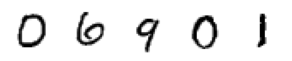

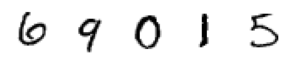

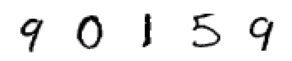

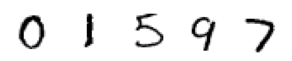

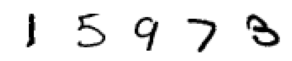

Reconstructed Images with Variational Autoencoder


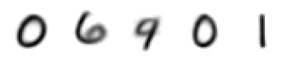

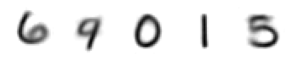

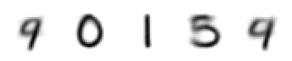

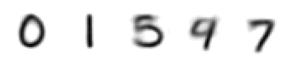

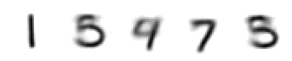

In [21]:
i = 10
print ("Real Test Images")
# Real Images
for k in range(5):
    plt.figure(figsize=(5,5))
    for j in range(5):
        plt.subplot(550 + 1 + j)
        plt.imshow(test_data[k+j+i,:,:, -1], cmap='gray_r')
        plt.axis('off')
    plt.show()

# Reconstructed Images
print ("Reconstructed Images with Variational Autoencoder")
for k in range(5):
    plt.figure(figsize=(5,5))
    for j in range(5):
        plt.subplot(550 + 1 + j)
        output = autoencoder.predict(np.array([test_data[k+j+i]]))
        op_image = np.reshape(output[0]*255, (28, 28))
        plt.imshow(op_image, cmap='gray_r')
        plt.axis('off')
    plt.show()

## Plot latent distribution, (color the classes)

In [23]:
x = []
y = []
k = []
for i in range(10000):
    k.append(testy[i])
    op = encoder_model.predict(np.array([test_data[i]]))
    x.append(op[0][0])
    y.append(op[0][1])

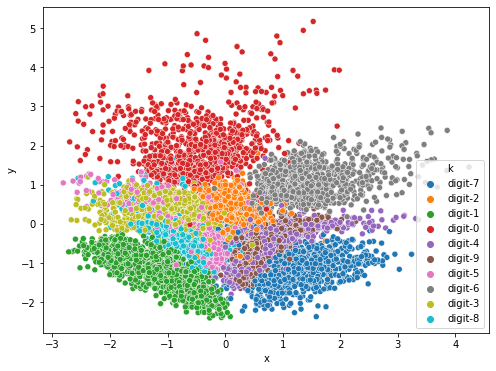

In [24]:
df = pd.DataFrame()
df['x'] = x
df['y'] = y
df['k'] = ["digit-"+str(i) for i in k]

plt.figure(figsize=(8, 6))
sns.scatterplot(x='x', y='y', hue='k', data=df)
plt.show()

## How to generate infinite data, with just the decocer part of the model?

In [25]:
generator_model = decoder_model

In [31]:
x_values = np.linspace(-2, 2, 30)
y_values = np.linspace(-2, 2, 30)

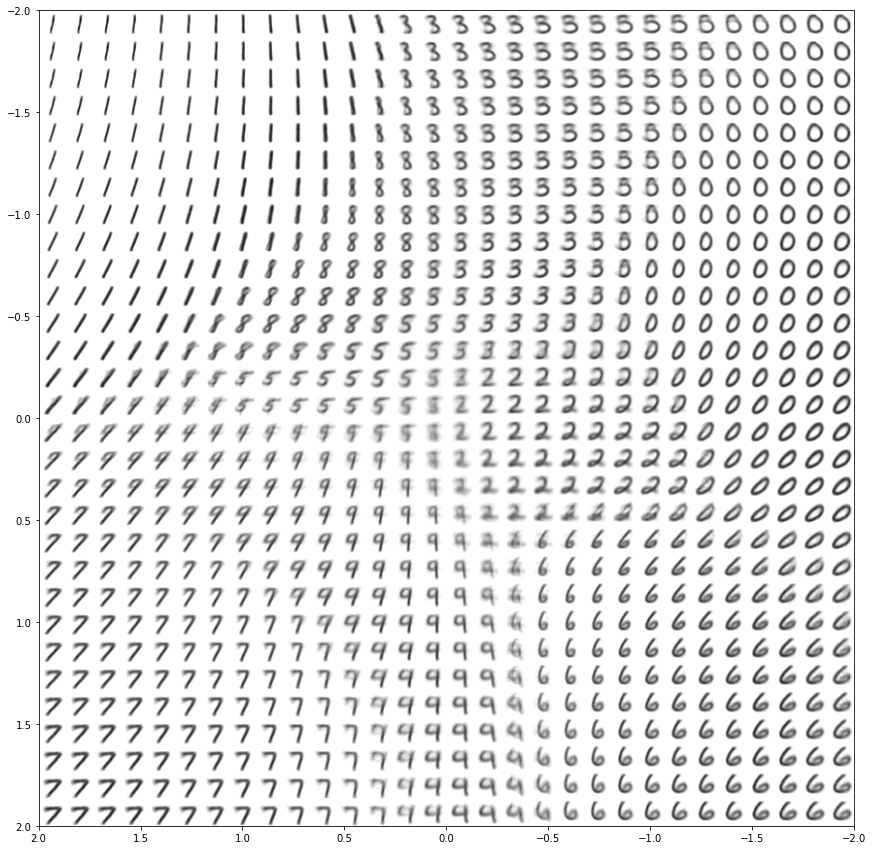

In [33]:
figure = np.zeros((28 * 30, 28 * 30))
for ix, x in enumerate(x_values):
    for iy, y in enumerate(y_values):
        latent_point = np.array([[x, y]])
        generated_image = generator_model.predict(latent_point)[0]
        figure[ix*28:(ix+1)*28, iy*28:(iy+1)*28,] = generated_image[:,:,-1]
 
plt.figure(figsize=(15, 15))
plt.imshow(figure, cmap='gray_r', extent=[2,-2,2,-2])
plt.show()